In [1]:
import os
import torch

In [2]:
from train import train
from build_model import build_model
from data import build_synthetic_dataset
from utils import Logger

import traceback
import shutil

In [3]:
global_config = dict(
    ver="mar_init",
    description="init",
    outcome_root="test",
)
global_config["outcome_dir_root"] = os.path.join(global_config["outcome_root"],
                                                 global_config["ver"])

transformer_config=dict(
    inp_dim = 8,
    dim = 16,
    out_dim = 8,
    num_layers = 4,
    num_heads = 8,
    ff_hidden_dim = 16,
    max_seq_len = 64,
    dropout = 0.0
)


mlp_config=dict(
    in_channels=transformer_config['inp_dim'],
    model_channels=16,
    out_channels=transformer_config['inp_dim'],
    z_channels=transformer_config['out_dim'],
    num_res_blocks=2,
    grad_checkpointing=False
)


diffusion_config=dict(
    num_steps = 64
)

train_config=dict(
    num_fm_per_gd=4,
    max_seq_len=transformer_config['max_seq_len'],
    train_steps=200,
    log_every_n_steps=50,
    eval_every_n_steps=100,
    pretrained=None,
    batch_size=32,
    base_learning_rate=3.0e-4,
    min_learning_rate=3.0e-5,
    use_lr_scheduler=False,
    warmup_steps=3,
    betas=[0.98, 0.999],
    need_check=False,
    use_ema=False,
    ema_decay=0.9999,
    ema_steps=20000
)
train_config['save']=train_config['train_steps']>0

dataset_paths={'afhq':'/kaggle/input/afhq-512',
               'ffhq':'/kaggle/input/flickrfaceshq-dataset-nvidia-resized-256px',
               'celebahq':'/kaggle/input/celebahq256-images-only',
               'fa':'/kaggle/input/face-attributes-grouped',
               'animestyle':'/kaggle/input/gananime-lite',
               'animefaces':'/kaggle/input/another-anime-face-dataset',
              }

data_config = dict(
    shape=(train_config['batch_size'],
           train_config['max_seq_len'],
           transformer_config['inp_dim']),
    image_size=256,
    batch_size=train_config['batch_size'],
    ae_batch_size=48,
    split=[0.5,0.25,0.25],
    data_paths=dataset_paths,
    enc_path=os.path.join(global_config["outcome_dir_root"], "enc"),
    enc_inp_path='/kaggle/input/sd-vae-ft-ema-f8-256-faces6-enc',
    dataset_names=['afhq', 'ffhq', 'celebahq', 'fa', 'animestyle', 'animefaces'],
    ignored_dataset=['fa'],
    ignored_dataset_ft=['ffhq', 'celebahq', 'animestyle', 'animefaces'],
    valid_dataset_idx=[]
)

In [4]:
logger = Logger(log_every_n_steps=train_config['log_every_n_steps'],
                log_root=global_config["outcome_dir_root"],
                model_name=global_config['ver']
               )

logger.log_text(str(global_config), "config")
logger.log_text(str(mlp_config), "config", newline=True)
logger.log_text(str(transformer_config), "config", newline=True)
logger.log_text(str(diffusion_config), "config", newline=True)
logger.log_text(str(train_config), "config", newline=True)

In [5]:
torch.manual_seed(42+hash(global_config['ver'])%10000)

train_dataset, val_dataset, test_dataset = build_synthetic_dataset(data_config)

logger.log_text(str(data_config), "config", newline=True)

In [6]:
model, optim, lr_scheduler = build_model(logger,
                                         transformer_config,
                                         mlp_config,
                                         diffusion_config,
                                         train_config)

T params: 7,640, MLP params: 8,136, TTrainable: 7,640
running on cuda


In [7]:
try:
    train(model, optim, lr_scheduler, train_config,
          train_dataset, val_dataset, test_dataset, logger)
except Exception as e:
    traceback.print_exc()
    info = traceback.format_exc()
    info = f"Exception: {str(info)} \n"+\
            f"Step: {logger.step}"
    print(info)
    logger.log_text(info, "error")
finally:
    if not any([fn.endswith('.pth') for fn in os.listdir(logger.log_root)]):
        if train_config['save']:
            logger.log_net(model.cpu(),f"mar_{logger.step}")
    shutil.make_archive(global_config["outcome_dir_root"],
                        'zip',
                        global_config["outcome_dir_root"])

Train step 50
loss: 1.9988
time per kstep: 54
peak GPU mem: 0.0 GB

Train step 100
loss: 1.9896
time per kstep: 22
peak GPU mem: 0.0 GB

Eval
loss:1.9685+-0.0178
Train step 150
loss: 1.9265
time per kstep: 165
peak GPU mem: 0.0 GB

Train step 200
loss: 1.8840
time per kstep: 22
peak GPU mem: 0.0 GB

Eval
loss:1.8683+-0.0174
Test
loss:1.8681+-0.0172


In [8]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
model.cuda()

In [ ]:
@torch.no_grad()
def synthesize_batch():
    b,s,d = data_config['shape']
    x1 = torch.ones((b,))
    x2 = torch.ones((d,))
    t = torch.linspace(-1,1,s)
    _,T,_=torch.meshgrid([x1,t,x2])
    return torch.sin(3.14*T*10)

In [ ]:
data = synthesize_batch()

In [ ]:
data = data[:,:32,:]

In [ ]:
g=model.gen(data.to(model.device),32)

In [ ]:
g_=g.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
g_.shape

(32, 64, 8)

(32.0, 64.0)

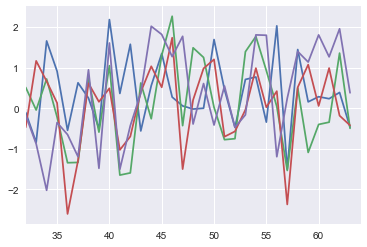

In [ ]:
plt.plot(g_[0,:,0])
plt.plot(g_[0,:,1])
plt.plot(g_[0,:,2])
plt.plot(g_[0,:,3])
plt.xlim([32,64])